# **Estimation of water quality in Hong Kong using Sentinel-2 images in GEE and artificial neural network (ANN) in Google Colab environment**

This is the second part of python codes used in the article. The codes are tested inside Google Colab environment using Hong Kong water as the study area.

**Import required libraries & Initialize Google Earth Engine session**

In [71]:
import ee
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
ee.Authenticate()
ee.Initialize()

# Step 1 - Match image data & in-situ station data

Sun glint correction & water mask are performed to each image in this step

In [8]:
# Load image data & in-situ station data
assetList = ee.data.getList({'id':"projects/ee-rsrohinsood/assets/S2_Py6S_mask_m"})
url = 'https://raw.githubusercontent.com/ivanhykwong/Marine-Water-Quality-Time-Series-HK/main/MarineQuality_2015-2020.csv'
station_list = ['TM2','TM3','TM4','TM5','TM6','TM7','TM8','SM1','SM2','SM3','SM4','SM5','SM6','SM7','SM9','SM10','SM11',
                'SM12','SM13','SM17','SM18','SM19','SM20','PM1','PM2','PM3','PM4','PM6','PM7','PM8','PM9','PM11','JM3',
                'JM4','DM1','DM2','DM3','DM4','DM5','NM1','NM2','NM3','NM5','NM6','NM8','MM1','MM2','MM3','MM4','MM5',
                'MM6','MM7','MM8','MM13','MM14','MM15','MM16','MM17','MM19','WM1','WM2','WM3','WM4','EM1','EM2','EM3',
                'VM1','VM2','VM4','VM5','VM6','VM7','VM8','VM12','VM14','VM15']
df_url = pd.read_csv(url)
df_url = df_url[df_url['Station'].isin(station_list)]
# print(assetList)
# print(len(assetList))
aoi = ee.Geometry.Polygon([[[113.800, 22.570],[113.800, 22.120],[114.514, 22.120],[114.514, 22.570]]])
df_data = pd.DataFrame()

pts = ee.FeatureCollection("projects/ee-rsrohinsood/assets/MonitoringStation_wgs84_76")
pt_list = pts.toList(pts.size())

for i in range(len(assetList)):
  # Extract image date
  assetid = assetList[i]['id']
  # print(assetid)
  d1 = ee.Image(assetid)
  d1_date = d1.date().format('yyyy-MM-dd')
  print(d1_date.getInfo())

  # sun glint correction by subtracting half of B11 from all bands
  # https://www.mdpi.com/2072-4292/1/4/697/htm
  # https://eatlas.org.au/data/uuid/2932dc63-9c9b-465f-80bf-09073aacaf1c
  swir_half = d1.select('B11').multiply(0.5)
  d1 = d1.subtract(swir_half)

  # water mask using MNDWI
  green = d1.select('B3')
  ndwi = d1.expression('(GREEN - SWIR) / (GREEN + SWIR)', {'GREEN': d1.select('B3'), 'SWIR': d1.select('B11')})
  mask = ndwi.gte(0.0).bitwiseAnd(green.gte(0.0)) # MNDWI >= 0
  d1 = d1.updateMask(mask)
  d1 = ee.Image(d1)

  # Find nearest date between image & station data
  df = df_url.copy()
  df['Dates'] = pd.to_datetime(df['Dates'], format='%Y-%m-%d')
  imagedate = datetime.strptime(d1_date.getInfo(), '%Y-%m-%d')
  df['Image_date'] = imagedate
  df['Date_compare'] = abs(df['Dates'] - imagedate)
  df = df.sort_values(by=['Date_compare'])
  df = df.drop_duplicates(subset=['Station'])

  if imagedate.year > 2020:
    continue

  df[['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']] = np.nan
  for pt in range(pt_list.length().getInfo()):
    pt1 = ee.Feature(pt_list.get(pt))
    pt1_buf = pt1.buffer(20)
    s2_dict = d1.reduceRegion(ee.Reducer.mean(), pt1_buf.geometry()).getInfo()
    n = pt1_buf.getInfo()['properties']['WaterStati']
    for b in ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']:
      df.loc[df['Station'] == n, b] = s2_dict[b]
  df = df.dropna(subset = ['B2'])
  df['n'] = df.shape[0]
  print(df.shape)

  # Combine all image dates
  df_data = pd.concat([df_data, df])

# Export tables
df_data.to_csv('df_data.csv')

2015-10-23
(54, 43)
2015-11-22
(62, 43)
2016-01-01
(73, 43)
2016-05-30
(31, 43)
2016-06-19
(56, 43)
2016-07-29
(42, 43)
2016-09-17
(71, 43)
2016-09-27
(70, 43)
2016-10-27
(46, 43)
2016-12-16
(74, 43)
2016-12-26
(59, 43)
2017-01-25
(76, 43)
2017-02-04
(74, 43)
2017-02-14
(72, 43)
2017-07-09
(44, 43)
2017-07-29
(22, 43)
2017-08-13
(35, 43)
2017-08-18
(45, 43)
2017-09-12
(48, 43)
2017-09-17
(70, 43)
2017-09-27
(68, 43)
2017-10-02
(43, 43)
2017-10-12
(69, 43)
2017-10-22
(76, 43)
2017-10-27
(75, 43)
2017-11-01
(76, 43)
2017-11-16
(55, 43)
2017-12-06
(76, 43)
2017-12-11
(76, 43)
2017-12-21
(71, 43)
2017-12-31
(76, 43)
2018-01-15
(74, 43)
2018-03-11
(49, 43)
2018-03-16
(72, 43)
2018-03-21
(34, 43)
2018-03-31
(33, 43)
2018-04-05
(22, 43)
2018-04-10
(30, 43)
2018-05-15
(22, 43)
2018-05-20
(39, 43)
2018-05-25
(17, 43)
2018-05-30
(50, 43)
2018-07-29
(48, 43)
2018-08-08
(20, 43)
2018-10-02
(68, 43)
2018-10-07
(68, 43)
2018-10-22
(41, 43)
2018-11-06
(73, 43)
2018-11-21
(72, 43)
2018-12-21
(56, 43)


This block is written for inputing csv file as the data, skip this block if the dataframe is already loaded

In [ ]:
# for inputing csv file as the data, skip this block if the dataframe is already loaded
df_data = pd.read_csv('df_data.csv')
df_data['Image_date'] = pd.to_datetime(df_data['Image_date'], format='%Y-%m-%d')
df_data['Date_compare'] = pd.to_timedelta(df_data['Date_compare'])
df_data = df_data.drop(columns=['Unnamed: 0'])

# Step 2 - Extract observations & create variables

Extract observations with ≤1 day difference; remove outliers & compute band combinations

In [10]:
# Extract observations with ≤1 day difference

max_day_diff = 1

df = df_data[['Image_date', 'Dates', 'Date_compare', 'n',
              '5-day Biochemical Oxygen Demand mg_L', 'Ammonia Nitrogen mg_L', 'Chlorophyll-a ug_L', 'Dissolved Oxygen mg_L',
              'E. coli cfu_100mL', 'Faecal Coliforms cfu_100mL', 'Nitrate Nitrogen mg_L', 'Nitrite Nitrogen mg_L',
              'Orthophosphate Phosphorus mg_L', 'pH', 'Salinity psu', 'Secchi Disc Depth M', 'Silica mg_L',
              'Suspended Solids mg_L', 'Temperature C', 'Total Inorganic Nitrogen mg_L', 'Total Kjeldahl Nitrogen mg_L',
              'Total Nitrogen mg_L', 'Total Phosphorus mg_L', 'Turbidity NTU', 'Unionised Ammonia mg_L', 'Volatile Suspended Solids mg_L',
              'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']].copy()

df = df.rename(columns={'Image_date': 'Image_Date', 'Dates': 'Station_Date',
                        '5-day Biochemical Oxygen Demand mg_L': 'BOD', 'Ammonia Nitrogen mg_L': 'AmNi', 'Chlorophyll-a ug_L': 'Chla', 'Dissolved Oxygen mg_L': 'DO',
                        'E. coli cfu_100mL': 'Ecoli', 'Faecal Coliforms cfu_100mL': 'FC', 'Nitrate Nitrogen mg_L': 'NitraNi', 'Nitrite Nitrogen mg_L': 'NitriNi',
                        'Orthophosphate Phosphorus mg_L': 'OrPh', 'pH': 'pH', 'Salinity psu': 'Sal', 'Secchi Disc Depth M': 'SDD', 'Silica mg_L': 'Si',
                        'Suspended Solids mg_L': 'SS', 'Temperature C': 'Temp', 'Total Inorganic Nitrogen mg_L': 'TIN', 'Total Kjeldahl Nitrogen mg_L': 'TKN',
                        'Total Nitrogen mg_L': 'ToNi', 'Total Phosphorus mg_L': 'ToPh', 'Turbidity NTU': 'Tur', 'Unionised Ammonia mg_L': 'UnAm', 'Volatile Suspended Solids mg_L': 'VSS'})

df['Date_compare'] = pd.to_numeric(df['Date_compare'].dt.days)
df['Image_Year'] = pd.DatetimeIndex(df['Image_Date']).year

df = df[(df['Date_compare'] <= max_day_diff) & (df['n'] >= 10)].copy().drop(columns=['Image_Date', 'Station_Date', 'Date_compare', 'n'])

# Remove outlier using Tukey’s fences method

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A']].any(axis=1)]

# Replace 0 to min/2 (avoid inf errors during evaluation)

wq = ['BOD', 'AmNi', 'Chla', 'DO', 'Ecoli', 'FC', 'NitraNi', 'NitriNi', 'OrPh', 'pH', 'Sal', 'SDD', 'Si', 'SS', 'Temp', 'TIN', 'TKN', 'ToNi', 'ToPh', 'Tur', 'UnAm', 'VSS']
for a in wq:
  df[a]=df[a].replace(0, np.NaN)
  df[a]=df[a].replace(np.NaN,df[a].min()/2)
df

,BOD,AmNi,Chla,DO,Ecoli,FC,NitraNi,NitriNi,OrPh,pH,...,B2,B3,B4,B5,B6,B7,B8A,B11,B12,Image_Year
1593,0.8,0.030,1.8,6.4,1,1.0,0.010,0.030,0.010,8.2,...,0.024012,0.021880,0.007361,0.005058,0.003775,0.004556,0.002365,-0.003005,-0.000928,2015
774,2.0,0.030,11.0,9.0,2,6.0,0.080,0.030,0.010,8.3,...,0.017895,0.023830,0.008918,0.007614,0.006212,0.007095,0.004357,-0.002521,-0.001166,2015
1525,1.0,0.030,6.2,6.5,3,4.0,0.010,0.010,0.010,8.0,...,0.020386,0.021324,0.004418,0.002513,0.002329,0.003834,0.001889,-0.003136,-0.001280,2015
1457,0.9,0.020,2.2,6.5,1,1.0,0.010,0.020,0.010,8.2,...,0.015285,0.012210,0.001578,-0.000646,-0.001609,-0.000103,-0.002289,-0.002975,-0.000215,2015
1251,0.9,0.030,1.5,6.9,1,1.0,0.010,0.020,0.010,8.2,...,0.033553,0.034266,0.012085,0.008210,0.005835,0.006444,0.004806,-0.001839,-0.000431,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,0.7,0.026,3.9,6.2,1,1.0,0.086,0.010,0.008,8.1,...,0.076209,0.074719,0.031725,0.025191,0.015815,0.014137,0.010753,0.006205,0.006669,2020
1719,0.6,0.027,2.7,5.9,1,1.0,0.098,0.012,0.009,8.0,...,0.055869,0.058048,0.022705,0.017965,0.012560,0.012884,0.009566,0.004793,0.005692,2020
1036,0.8,0.013,6.0,6.7,1,1.0,0.061,0.009,0.008,8.0,...,0.063186,0.067911,0.026093,0.019120,0.010664,0.010110,0.006447,0.001705,0.002828,2020
1104,0.8,0.017,6.3,6.5,1,1.0,0.055,0.008,0.009,7.9,...,0.040802,0.034904,0.014069,0.011599,0.009201,0.009556,0.006654,0.001376,0.001751,2020


In [11]:
# Create independent variables

bands = ['B' + str(b) for b in [*range(1,8),'8A',11,12]]
wl = [443,490,560,665,705,740,783,865,1610,2190]  #wavelength in nm

# Multiply 10
for i in bands:
  df[i] = df[i]*10

# Square and cubic
for i in bands:
  df[i+'_2'] = df[i]**2
  df[i+'_3'] = df[i]**3

# Two-band ratio
for i in bands:
  for j in bands:
    if (i != j) & (i < j):
      df['NR_'+i+j] = ((df[i] - df[j]) / (df[i] + df[j])).clip(lower=-1.0, upper=1.0)

# Three-band ratio
for i in range(0,10):
  for j in range(0,10):
    for k in range(0,10):
      if (j == i+1) & (k == j+1):
        df['TB_'+bands[i]+bands[j]+bands[k]] = (((1/df[bands[i]]) - (1/df[bands[j]])) * df[bands[k]]).clip(lower=-1.0, upper=1.0)

# Line height algorithm
for i in range(0,10):
  for j in range(0,10):
    for k in range(0,10):
      if (j == i+1) & (k == j+1):
        df['LH_'+bands[i]+bands[j]+bands[k]] = df[bands[j]] - df[bands[i]] - ((df[bands[k]] - df[bands[i]]) * ((wl[j]-wl[i])/(wl[k]-wl[i])))

df.to_csv('df_data_filter.csv')

/tmp/ipykernel_7705/945132734.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['TB_'+bands[i]+bands[j]+bands[k]] = (((1/df[bands[i]]) - (1/df[bands[j]])) * df[bands[k]]).clip(lower=-1.0, upper=1.0)
/tmp/ipykernel_7705/945132734.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['TB_'+bands[i]+bands[j]+bands[k]] = (((1/df[bands[i]]) - (1/df[bands[j]])) * df[bands[k]]).clip(lower=-1.0, upper=1.0)
/tmp/ipykernel_7705/945132734.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

This block is written for inputing csv file as the data, skip this block if the dataframe is already loaded

In [15]:
# for inputing csv file as the data, skip this block if the dataframe is already loaded
df = pd.read_csv('df_data_filter.csv')
df = df.drop(columns=['Unnamed: 0'])
wq = ['BOD', 'AmNi', 'Chla', 'DO', 'Ecoli', 'FC', 'NitraNi', 'NitriNi', 'OrPh', 'pH', 'Sal', 'SDD', 'Si', 'SS', 'Temp', 'TIN', 'TKN', 'ToNi', 'ToPh', 'Tur', 'UnAm', 'VSS']

# Step 3 - Train artificial neural network (ANN) models

Include selection of optimal variables through cross-validations; Based on GridSearchCV and MLPRegressor function in Scikit-learn

In [44]:
def min_max_normalize(df, exclude_cols=[]):
  """
  Normalizes each column of a DataFrame to a range between 0 and 1,
  excluding specified columns.

  Args:
      df (pandas.DataFrame): The DataFrame to normalize.
      exclude_cols (list, optional): List of column names to exclude from normalization. Defaults to [].

  Returns:
      pandas.DataFrame: The normalized DataFrame.
  """
  cols = list(df)
  normalized_df = df.copy()  # Create a copy to avoid modifying original data
  for col in cols:
    if col not in exclude_cols:
      normalized_df.loc[:, col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

  return normalized_df



In [57]:
# Define train and test datasets

df_train = df[df['Image_Year'] <= 2019].drop(columns=['Image_Year']).copy()
df_test = df[df['Image_Year'] == 2020].drop(columns=['Image_Year']).copy()
X_train = df_train.drop(columns = wq)
X_test = df_test.drop(columns = wq)

std_scaler = StandardScaler()
std_scaler.set_output(transform='pandas')

# Transform the data (centering and scaling features)
df_train_scaled = std_scaler.fit_transform(df_train)
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.fit_transform(X_test)

In [68]:
# Define ANN function based on MLPRegressor
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised

def ANN(df_train, X_train, wq_name, first, seed):
  print('seed:' + str(seed))
  print('var:' + str(first))
  print(wq_name)
  c = df_train.corr().copy()
  c = c[wq_name][22:113]
  c = abs(c).sort_values(ascending=False)[0:first]
  var = c.index.tolist()

  X_train2 = X_train[var]
  X_test2 = X_test[var]
  Y_train = df_train[wq_name]
  Y_test = df_test[wq_name]

  hidden_layer_sizes = [2,4,5,6,8,10,(2,2),(4,4),(5,5),(6,6),(8,8),(10,10)]
  tuned_parameters = {'hidden_layer_sizes': hidden_layer_sizes, 'alpha': 10.0 ** -np.arange(1, 7)}
  clf = GridSearchCV(MLPRegressor(random_state=seed,activation='logistic', solver='lbfgs', max_iter=50000, early_stopping=True),
                     param_grid=tuned_parameters, scoring='r2', verbose=1, cv=5)
  clf.fit(X_train2, Y_train)
  nvar = len(var)
  best_layer = clf.best_estimator_.hidden_layer_sizes
  best_alpha = clf.best_estimator_.alpha

  regr = MLPRegressor(random_state=seed, hidden_layer_sizes=best_layer, alpha=best_alpha, activation='logistic', 
                      solver='lbfgs', max_iter=50000, early_stopping=True).fit(X_train2, Y_train)

  r_squared = regr.score(X_train2, Y_train)
  adjusted_r_squared = 1 - (1-r_squared)*(len(Y_train)-1)/(len(Y_train)-X_train2.shape[1]-1)

  # Evaluate model
  Y_train_pred = regr.predict(X_train2)
  Y_train_pred[Y_train_pred<0]=0.0
  corr_model = np.corrcoef(Y_train, Y_train_pred)[0, 1]
  rmse = root_mean_squared_error(Y_train, Y_train_pred)
  mae = mean_absolute_error(Y_train, Y_train_pred)
  smape = np.mean(2*(np.abs(Y_train_pred - Y_train))/(np.abs(Y_train)+np.abs(Y_train_pred)))
  print(wq_name + ': ' + str(best_layer) + ', alpha: ' + str(best_alpha) + ', best_score: ' + str(clf.best_score_) + ', R2: ' + str(r_squared) + ', RMSE: ' + str(rmse))

  # Test model
  Y_test_pred = regr.predict(X_test2)
  Y_test_pred[Y_test_pred<0]=0.0
  r_squared_test = regr.score(X_test2, Y_test)
  corr_test = np.corrcoef(Y_test, Y_test_pred)[0, 1]
  rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
  mae_test = mean_absolute_error(Y_test, Y_test_pred)
  smape_test = np.mean(2*(np.abs(Y_test_pred - Y_test))/(np.abs(Y_test)+np.abs(Y_test_pred)))
  print(wq_name + ': r_squared_test: ' + str(r_squared_test) + ', rmse_test: ' + str(rmse_test) +  ', smape_test: ' + str(smape_test))

  ANN_df = pd.DataFrame({'WQ': [wq_name], 'nvar':[nvar], 'var':[var], 'random_state':[seed],
                         'best_layer':[best_layer], 'best_alpha':[best_alpha], 'best_score':[clf.best_score_],
                         'r2': [r_squared], 'adjusted_r2': [adjusted_r_squared], 'corr_model': [corr_model],
                         'rmse': [rmse], 'mae': [mae], 'smape': [smape],
                         'r2_test': [r_squared_test], 'corr_test': [corr_test],
                         'rmse_test': [rmse_test], 'mae_test': [mae_test], 'smape_test': [smape_test]})
  return(ANN_df)

In [72]:
# Apply ANN function to all water quality parameters
# this process is very time-consuming, reduce the number of wq parameters, reduce the cross-validation variables, or use parallel sessions

wq = ['Chla', 'SS', 'Tur']
ANN_result_list = [ANN(df_train_scaled, X_train_scaled, wq_name=value, first=f, seed=seed) for value in wq for f in range(4,13) for seed in range(1,11)]
ANN_result = pd.concat(ANN_result_list)

seed:1
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.13277558437648787, R2: 0.7757898787274747, RMSE: 0.5324746095090404
Chla: r_squared_test: -0.6196594437530263, rmse_test: 5.451464164649854, smape_test: 2.0
seed:2
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.08350880462044552, R2: 0.7762660940667394, RMSE: 0.5318648530142052
Chla: r_squared_test: -0.6190349496488328, rmse_test: 5.451464164649854, smape_test: 2.0
seed:3
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.001, best_score: 0.2514659365760166, R2: 0.788551943170394, RMSE: 0.5208535845671167
Chla: r_squared_test: -0.6193915610955179, rmse_test: 5.451464164649854, smape_test: 2.0
seed:4
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.1394777441089657, R2: 0.7488675000846594, RMSE: 0.5563573915319304
Chla: r_squared_test: -0.6165611343854791, rmse_test: 5.451464164649854, smape_test: 2.0
seed:5
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

Chla: 2, alpha: 0.01, best_score: 0.07236950465957567, R2: 0.7520609769706676, RMSE: 0.5537492830416894
Chla: r_squared_test: -0.6203154248960188, rmse_test: 5.451464164649854, smape_test: 2.0
seed:6
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Chla: (2, 2), alpha: 9.999999999999999e-06, best_score: 0.09277151245022394, R2: 0.752060991231081, RMSE: 0.5541353644398642
Chla: r_squared_test: -0.6211191637527167, rmse_test: 5.451464164649854, smape_test: 2.0
seed:7
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.14248714242722832, R2: 0.7489185720675059, RMSE: 0.5563043500880042
Chla: r_squared_test: -0.6166961127713346, rmse_test: 5.451464164649854, smape_test: 2.0
seed:8
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 9.999999999999999e-05, best_score: 0.16331520830392818, R2: 0.7615247288835967, RMSE: 0.5430639225519831
Chla: r_squared_test: -0.624411423586755, rmse_test: 5.451464164649854, smape_test: 2.0
seed:9
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.1256755139122821, R2: 0.7489285112186661, RMSE: 0.5563055613534741
Chla: r_squared_test: -0.6166644251068747, rmse_test: 5.451464164649854, smape_test: 2.0
seed:10
var:4
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 9.999999999999999e-06, best_score: 0.1871722155635081, R2: 0.7219032552586269, RMSE: 0.5706214824944981
Chla: r_squared_test: -0.47979099331692887, rmse_test: 5.368575259921137, smape_test: 1.767350493467083
seed:1
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

Chla: 2, alpha: 0.09999999999999999, best_score: -0.11142355703156182, R2: 0.762622338813181, RMSE: 0.5445686069054395
Chla: r_squared_test: -0.6154298664199402, rmse_test: 5.451464164649854, smape_test: 2.0
seed:2
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.01, best_score: 0.13058117585077542, R2: 0.7870389021123523, RMSE: 0.5219959907289556
Chla: r_squared_test: -0.6208794669062843, rmse_test: 5.451464164649854, smape_test: 2.0
seed:3
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.028720819150614106, R2: 0.74916394820282, RMSE: 0.5561825525783444
Chla: r_squared_test: -0.6159500788657519, rmse_test: 5.451464164649854, smape_test: 2.0
seed:4
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.06607560268667875, R2: 0.6571942722507047, RMSE: 0.594752439979424
Chla: r_squared_test: -0.5579774040148258, rmse_test: 5.451464164649854, smape_test: 2.0
seed:5
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.014437891188487706, R2: 0.749038527296284, RMSE: 0.5562861091561646
Chla: r_squared_test: -0.6158609298225506, rmse_test: 5.451464164649854, smape_test: 2.0
seed:6
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 9.999999999999999e-06, best_score: 0.10088315034806623, R2: 0.7503328118576368, RMSE: 0.553003614248986
Chla: r_squared_test: -0.5881174473334676, rmse_test: 5.451464164649854, smape_test: 2.0
seed:7
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.001, best_score: 0.09489460226945674, R2: 0.8092063749682622, RMSE: 0.5003861064461509
Chla: r_squared_test: -0.5962912783127519, rmse_test: 5.451464164649854, smape_test: 2.0
seed:8
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.017212767522583428, R2: 0.7490614764682973, RMSE: 0.5562789819588028
Chla: r_squared_test: -0.6158508588882361, rmse_test: 5.451464164649854, smape_test: 2.0
seed:9
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 9.999999999999999e-06, best_score: 0.10368389636506085, R2: 0.7818099014746475, RMSE: 0.52260212842263
Chla: r_squared_test: -0.6182686765376477, rmse_test: 5.451464164649854, smape_test: 2.0
seed:10
var:5
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.060370865710174096, R2: 0.7490161900841239, RMSE: 0.5562994712370456
Chla: r_squared_test: -0.6159470248392245, rmse_test: 5.451464164649854, smape_test: 2.0
seed:1
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (4, 4), alpha: 0.09999999999999999, best_score: -0.06845397115350182, R2: 0.8896133907252279, RMSE: 0.4179141419915496
Chla: r_squared_test: -0.6521316758669784, rmse_test: 5.451464164649854, smape_test: 2.0
seed:2
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (6, 6), alpha: 0.09999999999999999, best_score: 0.036547209898710055, R2: 0.9072107496712863, RMSE: 0.3974972200480526
Chla: r_squared_test: -0.6276299718623786, rmse_test: 5.451464164649854, smape_test: 2.0
seed:3
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (10, 10), alpha: 0.09999999999999999, best_score: 0.1863979822951966, R2: 0.9238113984658527, RMSE: 0.38224660391043863
Chla: r_squared_test: -0.5895199249110099, rmse_test: 5.451464164649854, smape_test: 2.0
seed:4
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (10, 10), alpha: 0.09999999999999999, best_score: 0.10956349786691524, R2: 0.9286322169551868, RMSE: 0.3776104254977549
Chla: r_squared_test: -0.595301987311037, rmse_test: 5.451464164649854, smape_test: 2.0
seed:5
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (6, 6), alpha: 0.09999999999999999, best_score: 0.024256858408961614, R2: 0.9061344922512401, RMSE: 0.39859896783140975
Chla: r_squared_test: -0.6176317408125238, rmse_test: 5.451464164649854, smape_test: 2.0
seed:6
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 8, alpha: 0.09999999999999999, best_score: -0.0239980831200985, R2: 0.9002980150988656, RMSE: 0.40690507818518157
Chla: r_squared_test: -0.5628269575284386, rmse_test: 5.451464164649854, smape_test: 2.0
seed:7
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 1e-06, best_score: 0.09836829341574553, R2: 0.7500583569349097, RMSE: 0.5271554371207977
Chla: r_squared_test: -0.582668045178651, rmse_test: 5.451464164649854, smape_test: 2.0
seed:8
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (6, 6), alpha: 0.09999999999999999, best_score: 0.13263878594377426, R2: 0.9140903040324986, RMSE: 0.3897846472935157
Chla: r_squared_test: -0.6247156998287502, rmse_test: 5.451464164649854, smape_test: 2.0
seed:9
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 4, alpha: 9.999999999999999e-05, best_score: 0.04275091595423548, R2: 0.8026364159195999, RMSE: 0.5002175308882887
Chla: r_squared_test: -0.684167069247416, rmse_test: 5.451464164649854, smape_test: 2.0
seed:10
var:6
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (10, 10), alpha: 0.09999999999999999, best_score: 0.20035142527952532, R2: 0.9226293923574674, RMSE: 0.38496716878184073
Chla: r_squared_test: -0.5723499767492595, rmse_test: 5.451464164649854, smape_test: 2.0
seed:1
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.01, best_score: -0.006851785325350246, R2: 0.7185551854398868, RMSE: 0.5703012544174503
Chla: r_squared_test: -0.6087901694966258, rmse_test: 5.451464164649854, smape_test: 2.0
seed:2
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 9.999999999999999e-06, best_score: 0.06691750211636227, R2: 0.822658428624548, RMSE: 0.4831518431460761
Chla: r_squared_test: -0.611700083937144, rmse_test: 5.451464164649854, smape_test: 2.0
seed:3
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (6, 6), alpha: 0.09999999999999999, best_score: -0.017488484798910343, R2: 0.923856262274237, RMSE: 0.3806187469743141
Chla: r_squared_test: -0.6279366796206867, rmse_test: 5.451464164649854, smape_test: 2.0
seed:4
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Chla: (5, 5), alpha: 0.09999999999999999, best_score: 0.12361523454195529, R2: 0.9092260475400582, RMSE: 0.3961615895143369
Chla: r_squared_test: -0.6478164613906661, rmse_test: 5.451464164649854, smape_test: 2.0
seed:5
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 9.999999999999999e-06, best_score: 0.16753279413942074, R2: 0.7313207822342839, RMSE: 0.5606025394013323
Chla: r_squared_test: -0.5727535638075618, rmse_test: 5.451464164649854, smape_test: 2.0
seed:6
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: 0.014709890987359397, R2: 0.7706644536420671, RMSE: 0.5399849887883055
Chla: r_squared_test: -0.6275418927363239, rmse_test: 5.451464164649854, smape_test: 2.0
seed:7
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Chla: 2, alpha: 0.09999999999999999, best_score: 0.048935166677962785, R2: 0.7436357352786174, RMSE: 0.560697775259615
Chla: r_squared_test: -0.6250475419531989, rmse_test: 5.451464164649854, smape_test: 2.0
seed:8
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.01871339740774791, R2: 0.8196276666209019, RMSE: 0.4927673165753976
Chla: r_squared_test: -0.6268219498502601, rmse_test: 5.451464164649854, smape_test: 2.0
seed:9
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: 0.04713704622428576, R2: 0.7704434283235304, RMSE: 0.5399793513159563
Chla: r_squared_test: -0.6273286793494135, rmse_test: 5.451464164649854, smape_test: 2.0
seed:10
var:7
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.01, best_score: 0.13723313519185718, R2: 0.7748551468675381, RMSE: 0.5379127892089929
Chla: r_squared_test: -0.6341304598946613, rmse_test: 5.451464164649854, smape_test: 2.0
seed:1
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (4, 4), alpha: 0.09999999999999999, best_score: 0.1581457203545396, R2: 0.8975537747097206, RMSE: 0.41141367991579114
Chla: r_squared_test: -0.6065277912248699, rmse_test: 5.451464164649854, smape_test: 2.0
seed:2
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (8, 8), alpha: 0.09999999999999999, best_score: -0.025545013886410794, R2: 0.9279208267234864, RMSE: 0.3797699947296737
Chla: r_squared_test: -0.615213516904501, rmse_test: 5.451464164649854, smape_test: 2.0
seed:3
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: 0.009183404387815907, R2: 0.8181155312899004, RMSE: 0.4939892128531611
Chla: r_squared_test: -0.6266398444823196, rmse_test: 5.451464164649854, smape_test: 2.0
seed:4
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.001, best_score: -0.030789721589810283, R2: 0.7796755307619734, RMSE: 0.5264629631261394
Chla: r_squared_test: -0.6281608080060896, rmse_test: 5.451464164649854, smape_test: 2.0
seed:5
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 5, alpha: 0.01, best_score: -0.10528108171822022, R2: 0.9182134841027332, RMSE: 0.3845546633328525
Chla: r_squared_test: -0.6377348537170293, rmse_test: 5.451464164649854, smape_test: 2.0
seed:6
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

Chla: (4, 4), alpha: 9.999999999999999e-06, best_score: -0.08683129063381745, R2: 0.8072522399728854, RMSE: 0.5038901624764794
Chla: r_squared_test: -0.6274411103988207, rmse_test: 5.451464164649854, smape_test: 2.0
seed:7
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: -0.00821686468660856, R2: 0.7614978455718153, RMSE: 0.546043018424296
Chla: r_squared_test: -0.6252960530434921, rmse_test: 5.451464164649854, smape_test: 2.0
seed:8
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Chla: (2, 2), alpha: 0.01, best_score: 0.005177119900132365, R2: 0.8231529674063262, RMSE: 0.4898194446361387
Chla: r_squared_test: -0.6278465358099228, rmse_test: 5.451464164649854, smape_test: 2.0
seed:9
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: 0.08491592408380426, R2: 0.7716095733383488, RMSE: 0.5381088042108471
Chla: r_squared_test: -0.625251809470226, rmse_test: 5.451464164649854, smape_test: 2.0
seed:10
var:8
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.01, best_score: 0.04502341827126266, R2: 0.7741704837173345, RMSE: 0.535399593096615
Chla: r_squared_test: -0.6263330895326227, rmse_test: 5.451464164649854, smape_test: 2.0
seed:1
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.001, best_score: -0.01894202454799876, R2: 0.8227726840962712, RMSE: 0.4902287045105619
Chla: r_squared_test: -0.6277453829307997, rmse_test: 5.451464164649854, smape_test: 2.0
seed:2
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 8, alpha: 0.09999999999999999, best_score: -0.10404941519840136, R2: 0.8966055463388853, RMSE: 0.4033626790326267
Chla: r_squared_test: -0.625968754390483, rmse_test: 5.451464164649854, smape_test: 2.0
seed:3
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (8, 8), alpha: 0.09999999999999999, best_score: 0.08507248979433113, R2: 0.9317437375005446, RMSE: 0.37450807552225174
Chla: r_squared_test: -0.6351333201328941, rmse_test: 5.451464164649854, smape_test: 2.0
seed:4
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.001, best_score: 0.052832217624853864, R2: 0.819762461574513, RMSE: 0.46279980141005206
Chla: r_squared_test: -0.5914709177702833, rmse_test: 5.451464164649854, smape_test: 2.0
seed:5
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: -0.0493863716751262, R2: 0.8195568426018116, RMSE: 0.4928232584909518
Chla: r_squared_test: -0.6269103311318629, rmse_test: 5.451464164649854, smape_test: 2.0
seed:6
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (6, 6), alpha: 0.09999999999999999, best_score: 0.07773761018463829, R2: 0.9098086752493743, RMSE: 0.39831594537821413
Chla: r_squared_test: -0.6247055865739959, rmse_test: 5.451464164649854, smape_test: 2.0
seed:7
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (10, 10), alpha: 0.09999999999999999, best_score: 0.028341437075048347, R2: 0.9379357973471155, RMSE: 0.36903036854839144
Chla: r_squared_test: -0.6474100468698332, rmse_test: 5.451464164649854, smape_test: 2.0
seed:8
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.01, best_score: 0.018431320667070407, R2: 0.7743530046100529, RMSE: 0.5360150381194536
Chla: r_squared_test: -0.6277282150568229, rmse_test: 5.451464164649854, smape_test: 2.0
seed:9
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.01, best_score: -0.03641518669472199, R2: 0.774416554997046, RMSE: 0.536808490952123
Chla: r_squared_test: -0.6290143907785497, rmse_test: 5.451464164649854, smape_test: 2.0
seed:10
var:9
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Chla: (4, 4), alpha: 0.09999999999999999, best_score: 0.01796628428399909, R2: 0.8987520191654488, RMSE: 0.41129897883274397
Chla: r_squared_test: -0.6238301998965601, rmse_test: 5.451464164649854, smape_test: 2.0
seed:1
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.001, best_score: 0.00915234523016133, R2: 0.804207597619133, RMSE: 0.5046901658056396
Chla: r_squared_test: -0.6238124439805064, rmse_test: 5.451464164649854, smape_test: 2.0
seed:2
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 5, alpha: 0.09999999999999999, best_score: -0.19231292519613755, R2: 0.9004665864779148, RMSE: 0.407777544480439
Chla: r_squared_test: -0.6335988725626842, rmse_test: 5.451464164649854, smape_test: 2.0
seed:3
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 5, alpha: 0.09999999999999999, best_score: 0.01272481441796327, R2: 0.9026158547820631, RMSE: 0.405666161667652
Chla: r_squared_test: -0.5978420343513928, rmse_test: 5.451464164649854, smape_test: 2.0
seed:4
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (10, 10), alpha: 0.09999999999999999, best_score: -0.13490259479673955, R2: 0.9376044661733357, RMSE: 0.3689068732312185
Chla: r_squared_test: -0.6465280024228048, rmse_test: 5.451464164649854, smape_test: 2.0
seed:5
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Chla: 8, alpha: 0.09999999999999999, best_score: -0.04285766652979397, R2: 0.9164279330461235, RMSE: 0.3889824098291109
Chla: r_squared_test: -0.5351631136993786, rmse_test: 5.440097322081143, smape_test: 1.9474101667327863
seed:6
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

Chla: 5, alpha: 0.09999999999999999, best_score: 0.005242839568588176, R2: 0.9009409927927567, RMSE: 0.40726421670530555
Chla: r_squared_test: -0.6328403379345271, rmse_test: 5.451464164649854, smape_test: 2.0
seed:7
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.01, best_score: -0.12403938842919378, R2: 0.8419629589727654, RMSE: 0.4610554180519285
Chla: r_squared_test: -0.6079124605324162, rmse_test: 5.451464164649854, smape_test: 2.0
seed:8
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: 0.04297683636509449, R2: 0.7669554970408385, RMSE: 0.542846256676812
Chla: r_squared_test: -0.6243617199807923, rmse_test: 5.451464164649854, smape_test: 2.0
seed:9
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 4, alpha: 0.09999999999999999, best_score: -0.1243075528634469, R2: 0.87246093825906, RMSE: 0.43376822133698045
Chla: r_squared_test: -0.6344595414247678, rmse_test: 5.451464164649854, smape_test: 2.0
seed:10
var:10
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (2, 2), alpha: 0.09999999999999999, best_score: -0.011350849366373206, R2: 0.7620033733356523, RMSE: 0.540264955209382
Chla: r_squared_test: -0.6199127180687116, rmse_test: 5.451464164649854, smape_test: 2.0
seed:1
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.01, best_score: 0.053436185111848424, R2: 0.7912272200948831, RMSE: 0.49132996082118785
Chla: r_squared_test: -0.5905108705083442, rmse_test: 5.451464164649854, smape_test: 2.0
seed:2
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: -0.0002634354946570827, R2: 0.8154002425431245, RMSE: 0.46923606418571245
Chla: r_squared_test: -0.5955607413858479, rmse_test: 5.451464164649854, smape_test: 2.0
seed:3
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (4, 4), alpha: 0.09999999999999999, best_score: -0.004833455309679468, R2: 0.9085708028546695, RMSE: 0.3936413891209927
Chla: r_squared_test: -0.6234631582838472, rmse_test: 5.451464164649854, smape_test: 2.0
seed:4
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: -0.10960849914052798, R2: 0.8432671276181052, RMSE: 0.46971042900105503
Chla: r_squared_test: -0.6277948869390615, rmse_test: 5.451464164649854, smape_test: 2.0
seed:5
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Chla: (5, 5), alpha: 0.09999999999999999, best_score: 0.10903810311093827, R2: 0.9095443272724583, RMSE: 0.394637638163952
Chla: r_squared_test: -0.6338199779580673, rmse_test: 5.451464164649854, smape_test: 2.0
seed:6
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: 0.15376009271954563, R2: 0.8434144986714298, RMSE: 0.46956147755583516
Chla: r_squared_test: -0.6273187126371151, rmse_test: 5.451464164649854, smape_test: 2.0
seed:7
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: -0.09794857512968871, R2: 0.8435780989252916, RMSE: 0.4694107471371675
Chla: r_squared_test: -0.6269870700273461, rmse_test: 5.451464164649854, smape_test: 2.0
seed:8
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: 0.19883226770542653, R2: 0.8433911750943189, RMSE: 0.469577613033166
Chla: r_squared_test: -0.6274721466887334, rmse_test: 5.451464164649854, smape_test: 2.0
seed:9
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: 0.07209885400668745, R2: 0.8489068200616298, RMSE: 0.4538451921492669
Chla: r_squared_test: -0.6128536635991595, rmse_test: 5.451464164649854, smape_test: 2.0
seed:10
var:11
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: 0.01671042044753508, R2: 0.8434960571732305, RMSE: 0.4694527000057797
Chla: r_squared_test: -0.6272986559878271, rmse_test: 5.451464164649854, smape_test: 2.0
seed:1
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (8, 8), alpha: 0.09999999999999999, best_score: -0.15208356447314644, R2: 0.9364785213273686, RMSE: 0.36690171337700134
Chla: r_squared_test: -0.6434139322383869, rmse_test: 5.451464164649854, smape_test: 2.0
seed:2
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 6, alpha: 0.09999999999999999, best_score: -0.16253228157554672, R2: 0.9161691036332615, RMSE: 0.39187426661091734
Chla: r_squared_test: -0.613729092065544, rmse_test: 5.451464164649854, smape_test: 2.0
seed:3
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (4, 4), alpha: 1e-06, best_score: -0.41808095793262867, R2: 0.95971773819585, RMSE: 0.33038972412899137
Chla: r_squared_test: -0.6270108012992477, rmse_test: 5.451464164649854, smape_test: 2.0
seed:4
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (6, 6), alpha: 0.09999999999999999, best_score: -0.45918206085656843, R2: 0.927497126803738, RMSE: 0.3802003959071497
Chla: r_squared_test: -0.6149561301717514, rmse_test: 5.451464164649854, smape_test: 2.0
seed:5
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 6, alpha: 0.09999999999999999, best_score: -0.28523685465132365, R2: 0.8963539974688494, RMSE: 0.4087975673617136
Chla: r_squared_test: -0.6166438283602853, rmse_test: 5.451464164649854, smape_test: 2.0
seed:6
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.001, best_score: -0.11293753593505393, R2: 0.838779048733183, RMSE: 0.4719228454620438
Chla: r_squared_test: -0.6206547289098812, rmse_test: 5.451464164649854, smape_test: 2.0
seed:7
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.09999999999999999, best_score: -0.26455485726203476, R2: 0.8491752322699276, RMSE: 0.4539733615224636
Chla: r_squared_test: -0.6127765649130472, rmse_test: 5.451464164649854, smape_test: 2.0
seed:8
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (8, 8), alpha: 0.09999999999999999, best_score: 0.014841589059716286, R2: 0.9329226190278461, RMSE: 0.3747263917393339
Chla: r_squared_test: -0.6650353202772663, rmse_test: 5.451464164649854, smape_test: 2.0
seed:9
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: 2, alpha: 0.001, best_score: -0.23820741602883802, R2: 0.8172423486907157, RMSE: 0.49197194198954913
Chla: r_squared_test: -0.6303523172085952, rmse_test: 5.451464164649854, smape_test: 2.0
seed:10
var:12
Chla
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Chla: (8, 8), alpha: 0.09999999999999999, best_score: -0.1421462052043493, R2: 0.9299141916150199, RMSE: 0.37604331201390706
Chla: r_squared_test: -0.6352888295052315, rmse_test: 5.451464164649854, smape_test: 2.0
seed:1
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

SS: 2, alpha: 0.09999999999999999, best_score: -0.04018033198308986, R2: 0.6474294947407859, RMSE: 0.652862396877466
SS: r_squared_test: -0.6919272051130687, rmse_test: 7.61599759215836, smape_test: 1.6212637765269535
seed:2
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.02896458420098862, R2: 0.6338502567881243, RMSE: 0.6629236462609865
SS: r_squared_test: -0.7235592050290813, rmse_test: 7.686861645502386, smape_test: 1.7850537300029576
seed:3
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.01, best_score: -0.053049204258052776, R2: 0.623140064279877, RMSE: 0.6659934717308568
SS: r_squared_test: -0.7574793212225317, rmse_test: 7.744559935273707, smape_test: 1.9952671567356444
seed:4
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 5, alpha: 0.01, best_score: -0.09537117019535783, R2: 0.742142375007198, RMSE: 0.5901297048579838
SS: r_squared_test: -0.6918136922358649, rmse_test: 7.615742105900563, smape_test: 1.6997937449318246
seed:5
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.01, best_score: -0.04528782731353185, R2: 0.6719348722740657, RMSE: 0.6360109212290933
SS: r_squared_test: -0.7557386559637396, rmse_test: 7.756188713254569, smape_test: 1.978045971207164
seed:6
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.03055734955621021, R2: 0.6306629773307456, RMSE: 0.6494717630995946
SS: r_squared_test: -0.7958986299056332, rmse_test: 7.7749350726945226, smape_test: 2.0
seed:7
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

SS: 2, alpha: 0.09999999999999999, best_score: -0.04348827148200389, R2: 0.6338905863411304, RMSE: 0.662992931589719
SS: r_squared_test: -0.7234597753659315, rmse_test: 7.6866399202825475, smape_test: 1.7844910045432696
seed:8
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.10572680047926139, R2: 0.7017395130345603, RMSE: 0.6161453781257106
SS: r_squared_test: -0.7510975761918781, rmse_test: 7.74524604443183, smape_test: 1.9829165372242221
seed:9
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.001, best_score: -0.10539045140686754, R2: 0.6293504372731016, RMSE: 0.6604167196867874
SS: r_squared_test: -0.756591642441707, rmse_test: 7.737228194694826, smape_test: 1.9926098481852845
seed:10
var:4
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.09999999999999999, best_score: -0.013079280116058545, R2: 0.6338341931957511, RMSE: 0.6629798541341834
SS: r_squared_test: -0.7234391850725868, rmse_test: 7.68659400373556, smape_test: 1.7842699137203049
seed:1
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.11595612070976942, R2: 0.6670174819099223, RMSE: 0.6411690413136969
SS: r_squared_test: -0.7813742191820416, rmse_test: 7.7720332979073525, smape_test: 1.9996469412107503
seed:2
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.09999999999999999, best_score: -0.07831776149691197, R2: 0.6477330770435614, RMSE: 0.655670980703151
SS: r_squared_test: -0.7045173689087176, rmse_test: 7.644281591840477, smape_test: 1.6650681410598382
seed:3
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.07433404105907952, R2: 0.6957603393148696, RMSE: 0.6258931215444494
SS: r_squared_test: -0.8928520152632136, rmse_test: 7.7749350726945226, smape_test: 2.0
seed:4
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 4, alpha: 0.09999999999999999, best_score: -0.06734808295227761, R2: 0.7027230889034497, RMSE: 0.617188152535923
SS: r_squared_test: -0.7435492569800806, rmse_test: 7.730817092427368, smape_test: 1.9232207333551008
seed:5
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.03815850638550296, R2: 0.6606213500373297, RMSE: 0.6424088131944414
SS: r_squared_test: -0.7377772745796749, rmse_test: 7.718501946328994, smape_test: 1.93653126568266
seed:6
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.05068400075411696, R2: 0.6139224312980116, RMSE: 0.6528604544809009
SS: r_squared_test: -0.8269539431292678, rmse_test: 7.7749350726945226, smape_test: 2.0
seed:7
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

SS: 2, alpha: 0.09999999999999999, best_score: -0.049491124137657994, R2: 0.6478628721998617, RMSE: 0.6555065930941943
SS: r_squared_test: -0.7049812408832297, rmse_test: 7.645321688832417, smape_test: 1.667332623115794
seed:8
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.021045578948816313, R2: 0.6617037884243915, RMSE: 0.6398563583586324
SS: r_squared_test: -0.7796929920270981, rmse_test: 7.7749350726945226, smape_test: 2.0
seed:9
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

SS: (2, 2), alpha: 0.09999999999999999, best_score: 0.004551192295149775, R2: 0.6414856808340421, RMSE: 0.6571995261519695
SS: r_squared_test: -0.723396567322258, rmse_test: 7.686498964881809, smape_test: 1.784424110019083
seed:10
var:5
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: (2, 2), alpha: 0.01, best_score: -0.055631327095901885, R2: 0.7040362197215861, RMSE: 0.6115283481044758
SS: r_squared_test: -0.7806448988764676, rmse_test: 7.765469492922098, smape_test: 1.998789776718458
seed:1
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.09656828782452236, R2: 0.6424265410371489, RMSE: 0.6564830371190327
SS: r_squared_test: -0.7260518504522206, rmse_test: 7.692418082969364, smape_test: 1.803045331749549
seed:2
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 5, alpha: 0.09999999999999999, best_score: -0.14348313997116818, R2: 0.7186228067471735, RMSE: 0.6061544820751772
SS: r_squared_test: -0.7258158635723444, rmse_test: 7.691892208907864, smape_test: 1.8041541708755249
seed:3
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.09030725005100775, R2: 0.6426519105376653, RMSE: 0.6563520856679954
SS: r_squared_test: -0.725897724765556, rmse_test: 7.692074632775015, smape_test: 1.8019171003942296
seed:4
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.12793990400165428, R2: 0.6103716823647606, RMSE: 0.682774717771391
SS: r_squared_test: -0.7242623874650647, rmse_test: 7.688429539102959, smape_test: 1.7636466388436753
seed:5
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.20027162686880792, R2: 0.6422675001231699, RMSE: 0.6566182743590638
SS: r_squared_test: -0.7253285047919853, rmse_test: 7.690806062936328, smape_test: 1.798130241889577
seed:6
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 5, alpha: 0.09999999999999999, best_score: -0.20156470282402447, R2: 0.7219211500379772, RMSE: 0.6048248222757948
SS: r_squared_test: -0.7633271286749064, rmse_test: 7.769811449931931, smape_test: 1.9947883266211937
seed:7
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.09999999999999999, best_score: -0.03887672493052061, R2: 0.6249527917251367, RMSE: 0.6500421637239402
SS: r_squared_test: -0.8029679436429316, rmse_test: 7.7749350726945226, smape_test: 2.0
seed:8
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

SS: 2, alpha: 0.09999999999999999, best_score: -0.04251928266297091, R2: 0.6082622639955055, RMSE: 0.685585545903709
SS: r_squared_test: -0.713268338732121, rmse_test: 7.663879291192246, smape_test: 1.6885746575554035
seed:9
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 4, alpha: 0.09999999999999999, best_score: -0.180037254614796, R2: 0.7225652375721152, RMSE: 0.603062446706871
SS: r_squared_test: -0.7771900914860959, rmse_test: 7.773306072468717, smape_test: 1.9999305441459267
seed:10
var:6
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.04110926544286926, R2: 0.6397863615859375, RMSE: 0.658282706527894
SS: r_squared_test: -0.7250628826902867, rmse_test: 7.690214023015528, smape_test: 1.795011697477064
seed:1
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 5, alpha: 0.09999999999999999, best_score: -0.1942974493383147, R2: 0.7238545894309065, RMSE: 0.602883212133813
SS: r_squared_test: -0.7438028822719598, rmse_test: 7.726979886431362, smape_test: 1.921374354424856
seed:2
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.1702573746057339, R2: 0.7234027728738389, RMSE: 0.6048556796004569
SS: r_squared_test: -0.7726521713278294, rmse_test: 7.772036561486542, smape_test: 1.9995998744862515
seed:3
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.07874087023552656, R2: 0.7287621748283828, RMSE: 0.5995452352436321
SS: r_squared_test: -0.7734918624506317, rmse_test: 7.768790255798256, smape_test: 1.999512244942547
seed:4
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.01, best_score: -0.11311648839247349, R2: 0.7081426708936072, RMSE: 0.6077059991718512
SS: r_squared_test: -0.8013801042422946, rmse_test: 7.767666064732191, smape_test: 1.9991516016120376
seed:5
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.07638113252310508, R2: 0.6869700901031677, RMSE: 0.6234531834431724
SS: r_squared_test: -0.8030422141685174, rmse_test: 7.772566511171637, smape_test: 1.999771100483103
seed:6
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.035931514155754504, R2: 0.7276680211840354, RMSE: 0.5988845768954538
SS: r_squared_test: -0.7726020522512398, rmse_test: 7.772572582360776, smape_test: 1.9998232814001113
seed:7
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 4, alpha: 0.09999999999999999, best_score: -0.1796230576362105, R2: 0.7237643049155918, RMSE: 0.6043037543953276
SS: r_squared_test: -0.7731688211113494, rmse_test: 7.771457285934098, smape_test: 1.9997194642284861
seed:8
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.052163991195684115, R2: 0.7189657274948219, RMSE: 0.6058120677878753
SS: r_squared_test: -0.7528761126339243, rmse_test: 7.749905274269429, smape_test: 1.9397132429524164
seed:9
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.08335269672909378, R2: 0.6484896797515596, RMSE: 0.6389022216322219
SS: r_squared_test: -0.7939245490673241, rmse_test: 7.7749350726945226, smape_test: 2.0
seed:10
var:7
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

SS: 2, alpha: 0.09999999999999999, best_score: -0.13326914615389274, R2: 0.6448299899462673, RMSE: 0.6570905860552345
SS: r_squared_test: -0.7358569350469673, rmse_test: 7.714236082767792, smape_test: 1.8600018224156958
seed:1
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.08578229584259127, R2: 0.7217845647069039, RMSE: 0.6055252215704093
SS: r_squared_test: -0.7653252230284959, rmse_test: 7.771212374982495, smape_test: 1.9976909305834154
seed:2
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 9.999999999999999e-05, best_score: -0.13633153221510666, R2: 0.6544758425538879, RMSE: 0.6514516051675311
SS: r_squared_test: -0.7064458560482336, rmse_test: 7.6465010380587435, smape_test: 1.6662454229426007
seed:3
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.07560753696967767, R2: 0.6886667598294101, RMSE: 0.6218198010050757
SS: r_squared_test: -0.8045702429922355, rmse_test: 7.772889304163231, smape_test: 1.9998193603957806
seed:4
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.1795405698368436, R2: 0.627443401466715, RMSE: 0.668504387560434
SS: r_squared_test: -0.7305366145474621, rmse_test: 7.702405123678005, smape_test: 1.8264346490863634
seed:5
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: 0.026158286709844547, R2: 0.6774789443499281, RMSE: 0.6252280073497876
SS: r_squared_test: -0.7203131602759958, rmse_test: 7.6796197543825855, smape_test: 1.778588039065723
seed:6
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.12964083270632448, R2: 0.7234969743862918, RMSE: 0.6037629049822194
SS: r_squared_test: -0.7683811976594008, rmse_test: 7.771297043965273, smape_test: 1.9994505338449224
seed:7
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.12065269689578759, R2: 0.7325185720850638, RMSE: 0.5992148377032289
SS: r_squared_test: -0.7852803301765459, rmse_test: 7.77383873678295, smape_test: 1.9999532469128058
seed:8
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.13258872114808434, R2: 0.6446513031329624, RMSE: 0.6575575855532986
SS: r_squared_test: -0.7366300423881114, rmse_test: 7.715953755615041, smape_test: 1.863801663083323
seed:9
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.1841984528713328, R2: 0.699980451850611, RMSE: 0.6207124933412254
SS: r_squared_test: -1.0113324018554946, rmse_test: 7.7749350726945226, smape_test: 2.0
seed:10
var:8
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.09999999999999999, best_score: -0.14577732974223304, R2: 0.6450291463307922, RMSE: 0.657238514687861
SS: r_squared_test: -0.736632746917818, rmse_test: 7.715959763808356, smape_test: 1.8638810514142745
seed:1
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.20833851142911924, R2: 0.6796344021010483, RMSE: 0.6322411373651144
SS: r_squared_test: -0.7831735574237615, rmse_test: 7.772674507932137, smape_test: 1.9997962795944022
seed:2
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 4, alpha: 0.09999999999999999, best_score: -0.3284982655875174, R2: 0.737568023744391, RMSE: 0.596305936493333
SS: r_squared_test: -0.8009169144783044, rmse_test: 7.7749350726945226, smape_test: 2.0
seed:3
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.09999999999999999, best_score: -0.20854029387868062, R2: 0.6298312442943784, RMSE: 0.6478445360468704
SS: r_squared_test: -0.7934919789388473, rmse_test: 7.773351028816528, smape_test: 1.999932459918514
seed:4
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.2967648567594131, R2: 0.7000683408721323, RMSE: 0.6285926711152302
SS: r_squared_test: -0.7737474059564005, rmse_test: 7.768434099444759, smape_test: 1.9992764985194624
seed:5
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.17188663308689014, R2: 0.6300909266993393, RMSE: 0.6475452454619743
SS: r_squared_test: -0.7934333685984729, rmse_test: 7.77327480230367, smape_test: 1.999929211631822
seed:6
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.14446948660166553, R2: 0.6683399425890469, RMSE: 0.6448880221309576
SS: r_squared_test: -0.7499852786684698, rmse_test: 7.745157921896435, smape_test: 1.9483996999759656
seed:7
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.1915695333979512, R2: 0.7040282013436394, RMSE: 0.6228984286777238
SS: r_squared_test: -0.7748556308518142, rmse_test: 7.7690423022045465, smape_test: 1.999305699823251
seed:8
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.2066621277018183, R2: 0.6622058677873298, RMSE: 0.6487957253298989
SS: r_squared_test: -0.7521444117695033, rmse_test: 7.749608954618037, smape_test: 1.9674990340946765
seed:9
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.2553709484275841, R2: 0.6622006302189538, RMSE: 0.6485896489515441
SS: r_squared_test: -0.7509978439111393, rmse_test: 7.747209551215821, smape_test: 1.9591430405752912
seed:10
var:9
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.5110503575170748, R2: 0.681603154825267, RMSE: 0.6234399383532864
SS: r_squared_test: -0.7375050091556461, rmse_test: 7.717897276342046, smape_test: 1.864395784469193
seed:1
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.01, best_score: -0.3212189698487037, R2: 0.6916041214074766, RMSE: 0.6223131987374798
SS: r_squared_test: -0.7249857642740589, rmse_test: 7.690042126744349, smape_test: 1.7652548692887928
seed:2
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.2484315211580721, R2: 0.7009168736415876, RMSE: 0.6284468429197303
SS: r_squared_test: -0.7752243260831762, rmse_test: 7.76888074410903, smape_test: 1.99929347621386
seed:3
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.33947982756864, R2: 0.6628297314358741, RMSE: 0.6450881229450495
SS: r_squared_test: -0.6930406287596083, rmse_test: 7.6185031482904915, smape_test: 1.5774196396299087
seed:4
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.11509168667644412, R2: 0.6843307389721313, RMSE: 0.6203903139145844
SS: r_squared_test: -0.7278659439782125, rmse_test: 7.6964594161206215, smape_test: 1.7950330942617685
seed:5
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.01, best_score: -0.3455511539256122, R2: 0.6912889551639869, RMSE: 0.6225323828578393
SS: r_squared_test: -0.7257833750764684, rmse_test: 7.691819808604426, smape_test: 1.7695805766232233
seed:6
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 9.999999999999999e-06, best_score: -0.32190052202494934, R2: 0.6940128544124751, RMSE: 0.5973324537712812
SS: r_squared_test: -0.7630531325962018, rmse_test: 7.774431861957912, smape_test: 1.9988854337774185
seed:7
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.01, best_score: -0.21807067103148828, R2: 0.692091283890272, RMSE: 0.6315166623777902
SS: r_squared_test: -0.731976999708581, rmse_test: 7.705076771697674, smape_test: 1.7951834505185227
seed:8
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.2798216013382695, R2: 0.6784724517749179, RMSE: 0.6380441850770477
SS: r_squared_test: -0.7311827866086573, rmse_test: 7.703843005557216, smape_test: 1.8109223054909287
seed:9
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.09999999999999999, best_score: -0.20586518392812075, R2: 0.6540652652695269, RMSE: 0.6480400658928086
SS: r_squared_test: -0.794418764055518, rmse_test: 7.774428465594385, smape_test: 1.9998906691129887
seed:10
var:10
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.01, best_score: -0.24283875301270794, R2: 0.69264945698579, RMSE: 0.630561973895979
SS: r_squared_test: -0.7315280944382536, rmse_test: 7.704084764224047, smape_test: 1.7922496061034405
seed:1
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.09999999999999999, best_score: -0.37784110872033383, R2: 0.6633767538589617, RMSE: 0.6453288483670833
SS: r_squared_test: -0.6810774505558259, rmse_test: 7.591538914782117, smape_test: 1.5120811075697103
seed:2
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.001, best_score: -0.22797740631159263, R2: 0.7052064328713099, RMSE: 0.6224669718932929
SS: r_squared_test: -0.7398007954895927, rmse_test: 7.716450362604611, smape_test: 1.8195879953742702
seed:3
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.3125117183009405, R2: 0.6654098239739088, RMSE: 0.6463154654042342
SS: r_squared_test: -0.745827368330743, rmse_test: 7.736358916005175, smape_test: 1.915132330309406
seed:4
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 1e-06, best_score: -0.21789683161322948, R2: 0.6757794664350035, RMSE: 0.6059137264069223
SS: r_squared_test: -0.8195975760167147, rmse_test: 7.7749350726945226, smape_test: 2.0
seed:5
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

SS: 2, alpha: 0.09999999999999999, best_score: -0.2839154511960805, R2: 0.6654657444115354, RMSE: 0.6462110363565251
SS: r_squared_test: -0.7465087950349185, rmse_test: 7.737868586245042, smape_test: 1.9193156169730767
seed:6
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 9.999999999999999e-05, best_score: -0.15699716027801186, R2: 0.7438137894636901, RMSE: 0.5720782940307332
SS: r_squared_test: -0.7851902779433171, rmse_test: 7.767380471137611, smape_test: 1.9946445350401143
seed:7
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.01, best_score: -0.25069829121097903, R2: 0.7013780692091174, RMSE: 0.622630467055135
SS: r_squared_test: -0.7327777310155426, rmse_test: 7.704018583540583, smape_test: 1.7852539684041338
seed:8
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: (2, 2), alpha: 0.001, best_score: -0.21578052570883247, R2: 0.772349046549482, RMSE: 0.5649014242870369
SS: r_squared_test: -0.7379973014542853, rmse_test: 7.710825078812422, smape_test: 1.8057438599308215
seed:9
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 1e-06, best_score: -0.3215774286462187, R2: 0.6075549982152973, RMSE: 0.6552325346649402
SS: r_squared_test: -0.7892771983415405, rmse_test: 7.729557271770689, smape_test: 1.9944874816481326
seed:10
var:11
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.12229282039242266, R2: 0.678811752938717, RMSE: 0.6366834340359514
SS: r_squared_test: -0.7289198248319335, rmse_test: 7.698806217043628, smape_test: 1.7929835848474018
seed:1
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.09999999999999999, best_score: -0.3362418186335105, R2: 0.6741556651284736, RMSE: 0.6400505498674259
SS: r_squared_test: -0.7872261476435578, rmse_test: 7.773592070307974, smape_test: 1.9997396323250658
seed:2
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.01, best_score: -0.34772350623307363, R2: 0.7096995089967932, RMSE: 0.6162971206641218
SS: r_squared_test: -0.7733547525798263, rmse_test: 7.756364183545737, smape_test: 1.9934982131236711
seed:3
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 9.999999999999999e-06, best_score: -0.20985355763215754, R2: 0.7712649981064295, RMSE: 0.5643127770623718
SS: r_squared_test: -0.7689797078123433, rmse_test: 7.741180522123365, smape_test: 1.8635385096552488
seed:4
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed t

SS: 2, alpha: 0.09999999999999999, best_score: -0.13183158872277023, R2: 0.6697861222638372, RMSE: 0.6430098408631473
SS: r_squared_test: -0.7471095722494634, rmse_test: 7.739199336894855, smape_test: 1.9223787938437196
seed:5
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.01, best_score: -0.22740808589917832, R2: 0.6444383316915632, RMSE: 0.6693356086311082
SS: r_squared_test: -0.7377903539349997, rmse_test: 7.718072877209371, smape_test: 1.8327470769486913
seed:6
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.2670176435678844, R2: 0.6187021436757366, RMSE: 0.6781512360841917
SS: r_squared_test: -0.7246759789158723, rmse_test: 7.689351579184593, smape_test: 1.7629271065372716
seed:7
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.001, best_score: -0.2830074020505638, R2: 0.721489823715575, RMSE: 0.6113065185076663
SS: r_squared_test: -0.7387131241575058, rmse_test: 7.709108131195448, smape_test: 1.8070485680972508
seed:8
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.09999999999999999, best_score: -0.42976807378042264, R2: 0.6716508091934508, RMSE: 0.6425790422738117
SS: r_squared_test: -0.7732886249563256, rmse_test: 7.771158632052762, smape_test: 1.9987716661327468
seed:9
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: 2, alpha: 0.001, best_score: -0.405370873542223, R2: 0.6700202081400597, RMSE: 0.6187235630391508
SS: r_squared_test: -0.7621159849988308, rmse_test: 7.733988706733266, smape_test: 1.9595977474055977
seed:10
var:12
SS
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

SS: (2, 2), alpha: 0.001, best_score: -0.3023752344723202, R2: 0.7422154048537035, RMSE: 0.5904573607619534
SS: r_squared_test: -0.8418423115561531, rmse_test: 7.767239345551443, smape_test: 1.9989326686289934
seed:1
var:4
Tur
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

Tur: 2, alpha: 0.09999999999999999, best_score: 0.05891857514600061, R2: 0.4904761776194979, RMSE: 0.7591614996712595
Tur: r_squared_test: -5.272826598485468, rmse_test: 4.729734095632081, smape_test: 2.0
seed:2
var:4
Tur
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rohinsood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", op

Tur: 2, alpha: 0.09999999999999999, best_score: 0.05907412152654603, R2: 0.4984265234434444, RMSE: 0.7631746798871699
Tur: r_squared_test: -4.945417932229298, rmse_test: 4.714108153584684, smape_test: 1.9946072334379343
seed:3
var:4
Tur
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

Tur: 2, alpha: 0.09999999999999999, best_score: 0.05963877974302571, R2: 0.4980427340000456, RMSE: 0.7633421642054479
Tur: r_squared_test: -4.953890816144696, rmse_test: 4.715355626777017, smape_test: 1.9956021039425513
seed:4
var:4
Tur
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

Tur: 2, alpha: 0.09999999999999999, best_score: 0.05919952590880464, R2: 0.4982239062534036, RMSE: 0.7632771898001753
Tur: r_squared_test: -4.952600243424429, rmse_test: 4.715086301918731, smape_test: 1.995447974663261
seed:5
var:4
Tur
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    

Tur: 2, alpha: 0.09999999999999999, best_score: 0.059675956449309564, R2: 0.4981295564174336, RMSE: 0.7633034374449219
Tur: r_squared_test: -4.952564578365958, rmse_test: 4.715121364625176, smape_test: 1.9954475939012875
seed:6
var:4
Tur
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/rohinsood/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Example output
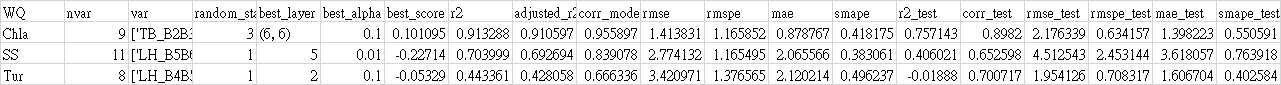

# Step 4 - Apply ANN models to all images

Output images are exported to image collections in GEE

In [ ]:
# Choose the optimal model according to the training results in previous step
# Obtain model parameters (first, seed, best_layer and best_alpha) that were used to create the optimal model (see Example Output above)
# Then obtain weights of each neuron (regr_int and regr_coef) from the model parameters

# Chla
wq_name='Chla'
first=9
seed=3
best_layer=(6,6)
best_alpha=0.1
activation='logistic'
c = df_train.corr().copy()
c = c[wq_name][22:113]
c = abs(c).sort_values(ascending=False)[0:first]
var = c.index.tolist()
X_train2 = X_train[var]
X_test2 = X_test[var]
Y_train = df_train[wq_name]
Y_test = df_test[wq_name]

regr = MLPRegressor(random_state=seed, hidden_layer_sizes=best_layer, alpha=best_alpha, activation=activation, solver='lbfgs', max_iter=10000, early_stopping=True).fit(X_train2, Y_train)
regr_int = regr.intercepts_
print(regr_int)
regr_coef = regr.coefs_
print(regr_coef)

# SS
wq_name='SS'
first=11
seed=1
best_layer=5
best_alpha=0.01
activation='logistic'
c = df_train.corr().copy()
c = c[wq_name][22:113]
c = abs(c).sort_values(ascending=False)[0:first]
var = c.index.tolist()
X_train2 = X_train[var]
X_test2 = X_test[var]
Y_train = df_train[wq_name]
Y_test = df_test[wq_name]

regr = MLPRegressor(random_state=seed, hidden_layer_sizes=best_layer, alpha=best_alpha, activation=activation, solver='lbfgs', max_iter=10000, early_stopping=True).fit(X_train2, Y_train)
regr_int = regr.intercepts_
print(regr_int)
regr_coef = regr.coefs_
print(regr_coef)

# Tur
wq_name='Tur'
first=8
seed=1
best_layer=2
best_alpha=0.1
activation='logistic'
c = df_train.corr().copy()
c = c[wq_name][22:113]
c = abs(c).sort_values(ascending=False)[0:first]
var = c.index.tolist()
X_train2 = X_train[var]
X_test2 = X_test[var]
Y_train = df_train[wq_name]
Y_test = df_test[wq_name]

regr = MLPRegressor(random_state=seed, hidden_layer_sizes=best_layer, alpha=best_alpha, activation=activation, solver='lbfgs', max_iter=10000, early_stopping=True).fit(X_train2, Y_train)
regr_int = regr.intercepts_
print(regr_int)
regr_coef = regr.coefs_
print(regr_coef)

In [ ]:
# Apply ANN model to entire image collection to estimate Chla

assetList = ee.data.getList({'id':"projects/ee-rsrohinsood/assets/S2_Py6S_mask_m"})
print(assetList)
print(len(assetList))
aoi = ee.Geometry.Polygon([[[113.800, 22.570],[113.800, 22.120],[114.514, 22.120],[114.514, 22.570]]])

for i in range(len(assetList)):
  assetid = assetList[i]['id']
  print(assetid)
  d1 = ee.Image(assetid)
  d1_date = d1.date().format('yyyy-MM-dd')
  print(d1_date.getInfo())
  imagedate = datetime.strptime(d1_date.getInfo(), '%Y-%m-%d')

  # sun glint correction & water mask
  swir_half = d1.select('B11').multiply(0.5)
  d1 = d1.subtract(swir_half)
  ndwi = d1.expression('(GREEN - NIR) / (GREEN + NIR)', {'GREEN': d1.select('B3'), 'NIR': d1.select('B8')})
  green = d1.select('B3')
  mask = ndwi.gte(0.0).bitwiseAnd(green.gte(0.0)) # NDWI >= 0
  d1 = d1.updateMask(mask)
  d1 = ee.Image(d1)

  # Chla
  name = ('Chla' + d1_date.getInfo()).replace('-','')
  regr_int = [([ 3.20462862, -4.79607408,  3.72196477,  4.01253827,  2.75393548, 0.16435048]),
              ([-8.74146412,  1.66061145,  0.35839572, -4.36972238,  2.15743342, -1.37527732]),
              ([-0.08353174])]
  # Var: ['TB_B2B3B4','LH_B3B4B5','LH_B1B2B3','LH_B7B8AB11','B2','NR_B2B3','B2_2','B8A_3','B1']
  # wl = [443,490,560,665,705,740,783,865,1610,2190]
  regr_coef = [([[-6.84163335e+00,  9.11557386e-06,  1.19411541e+00,1.21073081e+00,  1.17434541e+00,  8.92068972e+00],
          [ 1.06607504e-01, -1.74092425e-05,  2.85270757e-01, 3.47071654e+00,  6.96241402e+00, -3.52038843e+00],
          [ 4.29869179e+00,  1.02256279e-05,  2.65460603e+00, 1.74870671e+00, -3.90495929e+00, -4.54783495e-01],
          [ 1.17519063e+01,  4.75687333e-06,  6.04921374e-02, -5.21168117e+00, -2.80664876e+00,  1.13555655e+00],
          [-8.89242522e-01, -5.21662319e-08, -1.27341490e+00, -4.42972054e+00, -1.33156806e+01, -4.00857609e+00],
          [ 6.44798755e+00, -2.83891110e-05, -2.00038534e+00, 1.36985042e+01, -3.79913833e+00,  3.92121192e+00],
          [ 5.14241155e+00, -6.06040494e-06, -2.24315388e+00, -5.67994435e+00, -2.52787495e+00, -3.26207134e+00],
          [ 6.30920542e+00,  1.23064247e-05, -3.37502754e-02, 2.83332915e-01,  3.75643313e+00, -4.06294587e-01],
          [-8.35038133e+00, -3.68571701e-05, -5.79237965e+00, 1.48052989e+00, -9.32440766e+00, -3.83986207e+00]]),
      ([[-2.94657990e+00, -1.42551128e+01, -3.45316647e+00, -1.09401098e+01, -7.62867142e+00, -1.62820122e+00],
          [-6.15294982e-04, -2.50226568e-04,  2.28071787e-04, 6.44446416e-05,  1.58399756e-04,  1.03145638e-04],
          [ 2.12536696e-01, -6.21840984e+00,  2.45608299e+00, 2.26263141e+00,  1.26472416e+00,  2.88959971e-01],
          [ 5.46308778e-03,  6.95531564e+00, -1.77089020e+00, 1.00952176e+01, -2.91392188e+00, -3.57717559e+00],
          [ 8.38737781e+00, -6.48407937e-02, -1.47897332e+00, 1.24298506e+01,  9.11814110e+00,  3.07254104e+00],
          [ 6.86841847e+00,  7.39998611e+00,  2.06500733e+00, -5.27889971e+00,  5.32904476e+00,  3.87425016e+00]]),
      ([[13.20989264], [20.96326861], [ 7.10314308], [12.19847729], [-8.33632165], [ 8.97286496]])]
  B1 = d1.select('B1').multiply(10).rename('0')
  B2 = d1.select('B2').multiply(10).rename('0')
  B3 = d1.select('B3').multiply(10).rename('0')
  B4 = d1.select('B4').multiply(10).rename('0')
  B5 = d1.select('B5').multiply(10).rename('0')
  B6 = d1.select('B6').multiply(10).rename('0')
  B7 = d1.select('B7').multiply(10).rename('0')
  B8A = d1.select('B8A').multiply(10).rename('0')
  B11 = d1.select('B11').multiply(10).rename('0')
  B12 = d1.select('B12').multiply(10).rename('0')

  V1 = d1.expression('((1/B2)-(1/B3))*B4',{'B2': B2, 'B3': B3, 'B4': B4}).rename('0')
  V1 = V1.gte(-1.0).multiply(V1).subtract(V1.lt(-1.0))
  V1 = V1.lte(1.0).multiply(V1).add(V1.gt(1.0)).rename('0')
  V2 = d1.expression('B4-B3-(B5-B3)*((665-560)/(705-560))',{'B3': B3, 'B4': B4, 'B5': B5}).rename('0')
  V3 = d1.expression('B2-B1-(B3-B1)*((490-443)/(560-443))',{'B1':B1, 'B2': B2, 'B3': B3}).rename('0')
  V4 = d1.expression('B8A-B7-(B11-B7)*((865-783)/(1610-783))',{'B7': B7, 'B8A': B8A, 'B11': B11}).rename('0')
  V5 = B2
  V6 = d1.expression('(B2-B3)/(B2+B3)',{'B2': B2, 'B3': B3}).rename('0')
  V6 = V6.gte(-1.0).multiply(V6).subtract(V6.lt(-1.0))
  V6 = V6.lte(1.0).multiply(V6).add(V6.gt(1.0)).rename('0')
  V7 = B2.multiply(B2).rename('0')
  V8 = B8A.multiply(B8A).multiply(B8A).rename('0')
  V9 = B1

  N1 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][0], 'C1': regr_coef[0][0][0], 'C2': regr_coef[0][1][0], 'C3': regr_coef[0][2][0],
      'C4': regr_coef[0][3][0], 'C5': regr_coef[0][4][0], 'C6': regr_coef[0][5][0],
      'C7': regr_coef[0][6][0], 'C8': regr_coef[0][7][0], 'C9': regr_coef[0][8][0],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1) #sigmoid
  # N1 = N1.gte(0.0).multiply(N1) #relu

  N2 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][1], 'C1': regr_coef[0][0][1], 'C2': regr_coef[0][1][1], 'C3': regr_coef[0][2][1],
      'C4': regr_coef[0][3][1], 'C5': regr_coef[0][4][1], 'C6': regr_coef[0][5][1],
      'C7': regr_coef[0][6][1], 'C8': regr_coef[0][7][1], 'C9': regr_coef[0][8][1],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N3 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][2], 'C1': regr_coef[0][0][2], 'C2': regr_coef[0][1][2], 'C3': regr_coef[0][2][2],
      'C4': regr_coef[0][3][2], 'C5': regr_coef[0][4][2], 'C6': regr_coef[0][5][2],
      'C7': regr_coef[0][6][2], 'C8': regr_coef[0][7][2], 'C9': regr_coef[0][8][2],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N4 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][3], 'C1': regr_coef[0][0][3], 'C2': regr_coef[0][1][3], 'C3': regr_coef[0][2][3],
      'C4': regr_coef[0][3][3], 'C5': regr_coef[0][4][3], 'C6': regr_coef[0][5][3],
      'C7': regr_coef[0][6][3], 'C8': regr_coef[0][7][3], 'C9': regr_coef[0][8][3],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N5 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][4], 'C1': regr_coef[0][0][4], 'C2': regr_coef[0][1][4], 'C3': regr_coef[0][2][4],
      'C4': regr_coef[0][3][4], 'C5': regr_coef[0][4][4], 'C6': regr_coef[0][5][4],
      'C7': regr_coef[0][6][4], 'C8': regr_coef[0][7][4], 'C9': regr_coef[0][8][4],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N6 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9',{
      'Int': regr_int[0][5], 'C1': regr_coef[0][0][5], 'C2': regr_coef[0][1][5], 'C3': regr_coef[0][2][5],
      'C4': regr_coef[0][3][5], 'C5': regr_coef[0][4][5], 'C6': regr_coef[0][5][5],
      'C7': regr_coef[0][6][5], 'C8': regr_coef[0][7][5], 'C9': regr_coef[0][8][5],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9
  }).multiply(-1.0).exp().add(1).pow(-1)

  N21 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][0], 'C1': regr_coef[1][0][0], 'C2': regr_coef[1][1][0], 'C3': regr_coef[1][2][0],
      'C4': regr_coef[1][3][0], 'C5': regr_coef[1][4][0], 'C6': regr_coef[1][5][0],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N22 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][1], 'C1': regr_coef[1][0][1], 'C2': regr_coef[1][1][1], 'C3': regr_coef[1][2][1],
      'C4': regr_coef[1][3][1], 'C5': regr_coef[1][4][1], 'C6': regr_coef[1][5][1],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N23 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][2], 'C1': regr_coef[1][0][2], 'C2': regr_coef[1][1][2], 'C3': regr_coef[1][2][2],
      'C4': regr_coef[1][3][2], 'C5': regr_coef[1][4][2], 'C6': regr_coef[1][5][2],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N24 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][3], 'C1': regr_coef[1][0][3], 'C2': regr_coef[1][1][3], 'C3': regr_coef[1][2][3],
      'C4': regr_coef[1][3][3], 'C5': regr_coef[1][4][3], 'C6': regr_coef[1][5][3],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N25 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][4], 'C1': regr_coef[1][0][4], 'C2': regr_coef[1][1][4], 'C3': regr_coef[1][2][4],
      'C4': regr_coef[1][3][4], 'C5': regr_coef[1][4][4], 'C6': regr_coef[1][5][4],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  N26 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6',{
      'Int': regr_int[1][5], 'C1': regr_coef[1][0][5], 'C2': regr_coef[1][1][5], 'C3': regr_coef[1][2][5],
      'C4': regr_coef[1][3][5], 'C5': regr_coef[1][4][5], 'C6': regr_coef[1][5][5],
      'V1': N1, 'V2': N2, 'V3': N3, 'V4': N4, 'V5': N5, 'V6': N6
  }).multiply(-1.0).exp().add(1).pow(-1)

  d1_predict = d1.expression('Int+C1*N21+C2*N22+C3*N23+C4*N24+C5*N25+C6*N26',{
      'Int': regr_int[2][0], 'C1': regr_coef[2][0][0], 'C2': regr_coef[2][1][0], 'C3': regr_coef[2][2][0],
      'C4': regr_coef[2][3][0], 'C5': regr_coef[2][4][0], 'C6': regr_coef[2][5][0],
      'N21': N21, 'N22': N22, 'N23': N23, 'N24': N24, 'N25': N25, 'N26': N26
  })

  d1_predict = d1_predict.rename(name).set('system:time_start', ee.Date(d1_date).millis())

  task = ee.batch.Export.image.toAsset(image=d1_predict, description=name, assetId = 'projects/ee-rsrohinsood/assets/S2_Chla_ANN/' + name, scale = 10, region = aoi)
  task.start()

In [ ]:
# Apply ANN model to entire image collection to estimate Suspended Solids

assetList = ee.data.getList({'id':"projects/ee-rsrohinsood/assets/S2_Py6S_mask_m"})
print(assetList)
print(len(assetList))
aoi = ee.Geometry.Polygon([[[113.800, 22.570],[113.800, 22.120],[114.514, 22.120],[114.514, 22.570]]])

for i in range(len(assetList)):
  assetid = assetList[i]['id']
  print(assetid)
  d1 = ee.Image(assetid)
  d1_date = d1.date().format('yyyy-MM-dd')
  print(d1_date.getInfo())
  imagedate = datetime.strptime(d1_date.getInfo(), '%Y-%m-%d')

  # sun glint correction & water mask
  swir_half = d1.select('B11').multiply(0.5)
  d1 = d1.subtract(swir_half)
  ndwi = d1.expression('(GREEN - NIR) / (GREEN + NIR)', {'GREEN': d1.select('B3'), 'NIR': d1.select('B8')})
  green = d1.select('B3')
  mask = ndwi.gte(0.0).bitwiseAnd(green.gte(0.0)) # NDWI >= 0
  d1 = d1.updateMask(mask)
  d1 = ee.Image(d1)

  # SS
  name = ('SS' + d1_date.getInfo()).replace('-','')
  regr_int = [[12.55921704, -13.73353476, -1.56213489, -15.96103343, -2.74424462],
            [5.20100899]]
  # Var: ['LH_B5B6B7', 'LH_B4B5B6', 'B5_3', 'B5_2', 'B4_2', 'B4_3', 'B4', 'B5', 'B3_2', 'B3_3', 'B3']
  # wl = [443,490,560,665,705,740,783,865,1610,2190]
  regr_coef = [[[0.00315948251, -32.9780628, -5.07213985, 7.38647208, -28.4785664],
        [-0.000983638194, 25.9594867, 9.85539378, -15.2927115, -13.2072681],
        [-0.00164435665, 36.9788436, 3.02589409, -2.5088956, -1.45870294],
        [-0.00471352417, 20.1816497, 3.80586779, -7.21854322, -1.17430456],
        [-0.00635952648, -2.15180342, -5.37556561, 5.24388819, 10.5224534],
        [-0.00342851065, -8.5595385, 2.34126206, 4.644868, 1.65118437],
        [-0.010480811, 5.77984149, 36.2489087, 3.7447754, 28.9145655],
        [-0.00881720748, -35.9948876, 12.793081, -15.1404911, 15.8537979],
        [-0.0146337387, 7.69747295, -17.8781654, 13.9578202, -9.13328681],
        [-0.0106495051, -13.5599014, -0.717967751, 15.7539373, -14.516977],
        [-0.0179451399, 18.4680285, -1.31164633, 9.56437974, -0.594566828]],
    [[0.00693088504], [60.2560856], [-22.1701438], [2.36782265], [23.713127]]]
  B1 = d1.select('B1').multiply(10).rename('0')
  B2 = d1.select('B2').multiply(10).rename('0')
  B3 = d1.select('B3').multiply(10).rename('0')
  B4 = d1.select('B4').multiply(10).rename('0')
  B5 = d1.select('B5').multiply(10).rename('0')
  B6 = d1.select('B6').multiply(10).rename('0')
  B7 = d1.select('B7').multiply(10).rename('0')
  B8A = d1.select('B8A').multiply(10).rename('0')
  B11 = d1.select('B11').multiply(10).rename('0')
  B12 = d1.select('B12').multiply(10).rename('0')

  V1 = d1.expression('B6-B5-(B7-B5)*((740-705)/(783-705))',{'B5': B5, 'B6': B6, 'B7': B7}).rename('0')
  V2 = d1.expression('B5-B4-(B6-B4)*((705-665)/(740-665))',{'B4': B4, 'B5': B5, 'B6': B6}).rename('0')
  V3 = B5.multiply(B5).multiply(B5).rename('0')
  V4 = B5.multiply(B5).rename('0')
  V5 = B4.multiply(B4).rename('0')
  V6 = B4.multiply(B4).multiply(B4).rename('0')
  V7 = B4
  V8 = B5
  V9 = B3.multiply(B3).rename('0')
  V10 = B3.multiply(B3).multiply(B3).rename('0')
  V11 = B3

  N1 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][0], 'C1': regr_coef[0][0][0], 'C2': regr_coef[0][1][0], 'C3': regr_coef[0][2][0],
      'C4': regr_coef[0][3][0], 'C5': regr_coef[0][4][0], 'C6': regr_coef[0][5][0],
      'C7': regr_coef[0][6][0], 'C8': regr_coef[0][7][0], 'C9': regr_coef[0][8][0],
      'C10': regr_coef[0][9][0], 'C11': regr_coef[0][10][0],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1) #sigmoid

  N2 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][1], 'C1': regr_coef[0][0][1], 'C2': regr_coef[0][1][1], 'C3': regr_coef[0][2][1],
      'C4': regr_coef[0][3][1], 'C5': regr_coef[0][4][1], 'C6': regr_coef[0][5][1],
      'C7': regr_coef[0][6][1], 'C8': regr_coef[0][7][1], 'C9': regr_coef[0][8][1],
      'C10': regr_coef[0][9][1], 'C11': regr_coef[0][10][1],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1)

  N3 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][2], 'C1': regr_coef[0][0][2], 'C2': regr_coef[0][1][2], 'C3': regr_coef[0][2][2],
      'C4': regr_coef[0][3][2], 'C5': regr_coef[0][4][2], 'C6': regr_coef[0][5][2],
      'C7': regr_coef[0][6][2], 'C8': regr_coef[0][7][2], 'C9': regr_coef[0][8][2],
      'C10': regr_coef[0][9][2], 'C11': regr_coef[0][10][2],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1)

  N4 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][3], 'C1': regr_coef[0][0][3], 'C2': regr_coef[0][1][3], 'C3': regr_coef[0][2][3],
      'C4': regr_coef[0][3][3], 'C5': regr_coef[0][4][3], 'C6': regr_coef[0][5][3],
      'C7': regr_coef[0][6][3], 'C8': regr_coef[0][7][3], 'C9': regr_coef[0][8][3],
      'C10': regr_coef[0][9][3], 'C11': regr_coef[0][10][3],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1)

  N5 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8+C9*V9+C10*V10+C11*V11',{
      'Int': regr_int[0][4], 'C1': regr_coef[0][0][4], 'C2': regr_coef[0][1][4], 'C3': regr_coef[0][2][4],
      'C4': regr_coef[0][3][4], 'C5': regr_coef[0][4][4], 'C6': regr_coef[0][5][4],
      'C7': regr_coef[0][6][4], 'C8': regr_coef[0][7][4], 'C9': regr_coef[0][8][4],
      'C10': regr_coef[0][9][4], 'C11': regr_coef[0][10][4],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11
  }).multiply(-1.0).exp().add(1).pow(-1)

  d1_predict = d1.expression('Int+C1*N1+C2*N2+C3*N3+C4*N4+C5*N5',{
      'Int': regr_int[1][0], 'C1': regr_coef[1][0][0], 'C2': regr_coef[1][1][0], 'C3': regr_coef[1][2][0],
      'C4': regr_coef[1][3][0], 'C5': regr_coef[1][4][0],
      'N1': N1, 'N2': N2, 'N3': N3, 'N4': N4, 'N5': N5
  })

  d1_predict = d1_predict.rename(name).set('system:time_start', ee.Date(d1_date).millis())

  task = ee.batch.Export.image.toAsset(image=d1_predict, description=name, assetId = 'projects/ee-rsrohinsood/assets/S2_SS_ANN/' + name, scale = 10, region = aoi)
  task.start()

In [ ]:
# Apply ANN model to entire image collection to estimate Turbidity

assetList = ee.data.getList({'id':"projects/ee-rsrohinsood/assets/S2_Py6S_mask_m"})
print(assetList)
print(len(assetList))
aoi = ee.Geometry.Polygon([[[113.800, 22.570],[113.800, 22.120],[114.514, 22.120],[114.514, 22.570]]])

for i in range(len(assetList)):
  assetid = assetList[i]['id']
  print(assetid)
  d1 = ee.Image(assetid)
  d1_date = d1.date().format('yyyy-MM-dd')
  print(d1_date.getInfo())
  imagedate = datetime.strptime(d1_date.getInfo(), '%Y-%m-%d')

  # sun glint correction & water mask
  swir_half = d1.select('B11').multiply(0.5)
  d1 = d1.subtract(swir_half)
  ndwi = d1.expression('(GREEN - NIR) / (GREEN + NIR)', {'GREEN': d1.select('B3'), 'NIR': d1.select('B8')})
  green = d1.select('B3')
  mask = ndwi.gte(0.0).bitwiseAnd(green.gte(0.0)) # NDWI >= 0
  d1 = d1.updateMask(mask)
  d1 = ee.Image(d1)

  # Tur
  name = ('Tur' + d1_date.getInfo()).replace('-','')
  regr_int = [[1.03043919, -5.1108822], [26.60795985]]
  # Var: ['LH_B4B5B6', 'LH_B5B6B7', 'LH_B2B3B4', 'B3_3', 'B3_2', 'B5_3', 'B3', 'B5_2']
  # wl = [443,490,560,665,705,740,783,865,1610,2190]
  regr_coef = [[[-24.70594813, 14.37269736],
                [1.01369778, 0.71021701],
                [5.39600925, 7.8477396],
                [-5.40222666, -13.46987698],
                [-3.67650209, 1.77537138],
                [-1.75628292, 6.8203711],
                [5.18825675, 7.52539217],
                [10.51626892, 8.31789011]],
              [[-27.16748834], [16.79998435]]]
  B1 = d1.select('B1').multiply(10).rename('0')
  B2 = d1.select('B2').multiply(10).rename('0')
  B3 = d1.select('B3').multiply(10).rename('0')
  B4 = d1.select('B4').multiply(10).rename('0')
  B5 = d1.select('B5').multiply(10).rename('0')
  B6 = d1.select('B6').multiply(10).rename('0')
  B7 = d1.select('B7').multiply(10).rename('0')
  B8A = d1.select('B8A').multiply(10).rename('0')
  B11 = d1.select('B11').multiply(10).rename('0')
  B12 = d1.select('B12').multiply(10).rename('0')

  V1 = d1.expression('B5-B4-(B6-B4)*((705-665)/(740-665))',{'B4': B4, 'B5': B5, 'B6': B6}).rename('0')
  V2 = d1.expression('B6-B5-(B7-B5)*((740-705)/(783-705))',{'B5': B5, 'B6': B6, 'B7': B7}).rename('0')
  V3 = d1.expression('B3-B2-(B4-B2)*((560-490)/(665-490))',{'B2': B2, 'B3': B3, 'B4': B4}).rename('0')
  V4 = B3.multiply(B3).multiply(B3).rename('0')
  V5 = B3.multiply(B3).rename('0')
  V6 = B5.multiply(B5).multiply(B5).rename('0')
  V7 = B3
  V8 = B5.multiply(B5).rename('0')

  N1 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8',{
      'Int': regr_int[0][0], 'C1': regr_coef[0][0][0], 'C2': regr_coef[0][1][0], 'C3': regr_coef[0][2][0],
      'C4': regr_coef[0][3][0], 'C5': regr_coef[0][4][0], 'C6': regr_coef[0][5][0],
      'C7': regr_coef[0][6][0], 'C8': regr_coef[0][7][0],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8
  }).multiply(-1.0).exp().add(1).pow(-1) #sigmoid

  N2 = d1.expression('Int+C1*V1+C2*V2+C3*V3+C4*V4+C5*V5+C6*V6+C7*V7+C8*V8',{
      'Int': regr_int[0][1], 'C1': regr_coef[0][0][1], 'C2': regr_coef[0][1][1], 'C3': regr_coef[0][2][1],
      'C4': regr_coef[0][3][1], 'C5': regr_coef[0][4][1], 'C6': regr_coef[0][5][1],
      'C7': regr_coef[0][6][1], 'C8': regr_coef[0][7][1],
      'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7, 'V8': V8
  }).multiply(-1.0).exp().add(1).pow(-1)

  d1_predict = d1.expression('Int+C1*N1+C2*N2',{
      'Int': regr_int[1][0], 'C1': regr_coef[1][0][0], 'C2': regr_coef[1][1][0],
      'N1': N1, 'N2': N2
  })

  d1_predict = d1_predict.rename(name).set('system:time_start', ee.Date(d1_date).millis())

  task = ee.batch.Export.image.toAsset(image=d1_predict, description=name, assetId = 'projects/ee-rsrohinsood/assets/S2_Tur_ANN/' + name, scale = 10, region = aoi)
  task.start()